In [1]:
"""
The project leverages word vector representations to create an Emojifier. It takes as input a sentence and
identifies the most suitable emoji for it. Examples include:
    Job well done! 👍
    Let's get coffee and talk. ☕️
    I love you! ❤️
    Let's watch the baseball game tomorrow! ⚾️
"""

from utils_emojify import *
import os
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation
from tensorflow.keras.layers import Embedding
%matplotlib inline
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
# IMPORT THE DATASET
train_data_path = os.path.join(os.getcwd(), 'data', 'train_emoji.csv')
test_data_path = os.path.join(os.getcwd(), 'data', 'test_emoji.csv')

X_train, Y_train = read_csv_reader(train_data_path)
X_test, Y_test = read_csv_reader(test_data_path)

In [3]:
# Looking at some of the examples in the dataset
for idx in range(5):
    print(X_train[idx], convert_label_to_emoji(Y_train[idx]))

never talk to me again 😞
I am proud of your achievements 😄
It is the worst day in my life 😞
Miss you so much ❤️
food is life 🍴


In [4]:
# Note that the sentences have different lengths
# Convert each word in the input sentence into their word vector representations
glove_file = os.path.join(os.getcwd(), 'data', 'glove.6B.100d.txt')  
word_to_index, index_to_word, word_to_vec_map = read_glove_vectors(glove_file)

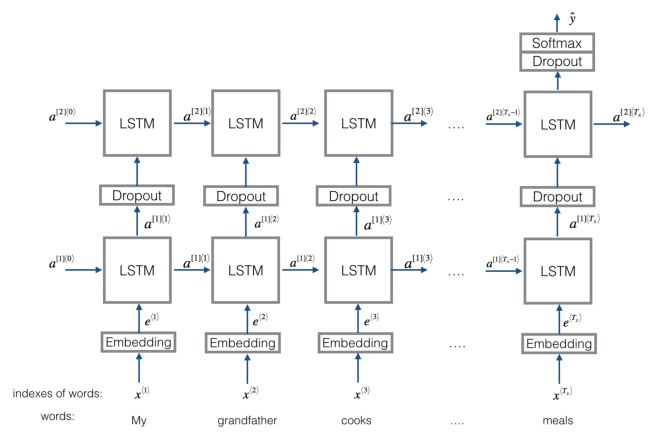

In [5]:
# BUILDING THE EMOJIFIER
# Here is the model to build
model_img = plt.imread(os.path.join(os.getcwd(), 'images', 'emojifier_v2.png'))
plt.imshow(model_img)
plt.axis("off")
plt.subplots_adjust(left=0, bottom=0, right=1, top=1)

In [6]:
# One-hot encoding the targets
C = len(label_to_emoji_dict.keys())  # Number of classes
Y_oh_train = convert_to_one_hot(Y_train, num_classes=C)
Y_oh_test = convert_to_one_hot(Y_test, num_classes=C)

# Verification
idx = 10
print(f"The sentence '{X_train[idx]}' has label index '{Y_train[idx]}',"
      f" which is emoji {convert_label_to_emoji(Y_train[idx])}", )
print(f"Label index '{Y_train[idx]}' in one-hot encoding format is {Y_oh_train[idx]}")

The sentence 'she did not answer my text ' has label index '3', which is emoji 😞
Label index '3' in one-hot encoding format is [0. 0. 0. 1. 0. 0.]


In [7]:
# Note: Most DL frameworks require that all sequences in the same mini-batch have the same length.
# Given a defined max sequence length, we could pad every sentence with "0"s so that each input has the same length.

maxLen = len(max(X_train, key=lambda x: len(x.split())).split())  # Find the length of the longest sentence.
print(f"The length of the longest sentence in the training set: {maxLen}")

The length of the longest sentence in the training set: 10


In [8]:
# Sentence to indices
def sentences_to_indices(X, words_to_indices, max_len):
    """
    Converts an array of sentences into an array of indices corresponding to words in the sentences.

    Arguments:
        X (numpy.ndarray): Array of sentences (strings), of shape (m,).
        words_to_indices (dict): Python dictionary mapping each word to its index.
        max_len (int): Maximum number of words in a sentence. Assumes each sentence in X is no longer than this.

    Returns:
        numpy.ndarray: Array of indices corresponding to words in the sentences from X, of shape (m, max_len).

    The function performs the following steps:
        1. Initializes an array of zeros with shape (m, max_len).
        2. Converts each sentence to lower case and splits it into words.
        3. Maps each word to its index using the word_to_index dictionary.
        4. Stores the indices in the corresponding row of the output array.
    """
    m = X.shape[0]  # Number of training examples

    # Initialize X_indices as a numpy matrix of zeros with the correct shape
    X_indices = np.zeros((m, max_len))

    for i in range(m):
        # Convert the i-th training sentence to lower case and split it into words
        sentence_words = X[i].lower().split()

        j = 0
        for w in sentence_words:
            if w in word_to_index:
                X_indices[i, j] = words_to_indices[w]
                j += 1

    return X_indices

In [9]:
#  Verification
dummy = np.array(["funny lol", "lets play baseball", "food is ready for you"])
dummy_indices = sentences_to_indices(dummy, word_to_index, max_len=5)
print("Sentences:\n", dummy)
print("Sentences_indices:\n", dummy_indices)

Sentences:
 ['funny lol' 'lets play baseball' 'food is ready for you']
Sentences_indices:
 [[155345. 225122.      0.      0.      0.]
 [220930. 286375.  69714.      0.      0.]
 [151204. 192973. 302254. 151349. 394475.]]


In [10]:
# Build the embedding layer
def pretrained_embedding_layer(word_to_vector_map, words_to_indices, training=False):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe vectors.

    Arguments:
        word_to_vector_map (dict): Python dictionary mapping words to their GloVe vector representation.
        words_to_indices (dict): Python dictionary mapping from words to their indices in the vocabulary (400,001 words)
        training (bool) -- If the embedding layer should be trained. Default value is False.

    Returns:
        emb_layer -- A pre-trained layer Keras instance
    """

    vocab_size = len(words_to_indices) + 1  # adding 1 to fit Keras embedding (requirement)
    any_word = next(iter(word_to_vector_map.keys()))
    emb_dim = word_to_vector_map[any_word].shape[0]  # Extract dimensionality of your GloVe word vectors

    # Initialize the embedding matrix as a numpy array of zeros.
    emb_matrix = np.zeros((vocab_size, emb_dim))

    # Set each row "id" of the embedding matrix to be
    for w, id_x in words_to_indices.items():
        emb_matrix[id_x, :] = word_to_vector_map[w]

    # Define Keras embedding layer with the correct input and output sizes
    # Make it non-trainable.
    emb_layer = Embedding(vocab_size, emb_dim, trainable=training)

    # Build the embedding layer, it is required before setting the weights of the embedding layer.
    emb_layer.build((None,))

    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pre-trained.
    emb_layer.set_weights([emb_matrix])

    return emb_layer

In [11]:
# Verification
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][1] =", embedding_layer.get_weights()[0][1][1])
print("Input_dim", embedding_layer.input_dim)
print("Output_dim", embedding_layer.output_dim)

weights[0][1][1] = 0.49351
Input_dim 400001
Output_dim 100


In [12]:
# The model
def Emojify_v2(input_shape, word_to_vector_map, words_to_indices, hidden_state_dim=128, dropout=0.5, num_classes=5):
    """
    Builds the Emojify-v2 model using LSTM layers and pretrained GloVe embeddings.

    Arguments:
        input_shape (tuple): The shape of the input, usually (max_len,).
        word_to_vector_map (dict): A dictionary mapping words to their GloVe vector representations.
        words_to_indices (dict): A dictionary mapping words to their indices in the vocabulary.
        hidden_state_dim (int): The number of units in the LSTM layer. Default is 128.
        dropout (float): The dropout rate to apply after each LSTM layer. Default is 0.5.
        num_classes (int): The number of output classes. Default is 5.

    Returns:
        Model: A Keras model instance.
    """
    # Define sentence_indices as the input of the graph
    sentence_indices = Input(shape=input_shape, dtype='int32')  # dtype='int32' as it contains indices (integers)

    # Create the embedding layer pretrained with GloVe vectors
    emb_layer = pretrained_embedding_layer(word_to_vector_map, words_to_indices)

    # Pass sentence_indices through the embedding layer
    embeddings = emb_layer(sentence_indices)

    # Add LSTM layers with hidden state dimension
    X = LSTM(units=hidden_state_dim, return_sequences=True)(embeddings)
    X = Dropout(rate=dropout)(X)
    X = LSTM(units=hidden_state_dim, return_sequences=False)(X)
    X = Dropout(rate=dropout)(X)

    # Add a dense output layer with a softmax activation
    X = Dense(units=num_classes)(X)
    X = Activation('softmax')(X)

    # Create the model
    emojify_model = Model(inputs=sentence_indices, outputs=X)

    return emojify_model

In [13]:
# Initialize the model
model = Emojify_v2((maxLen,), word_to_vec_map, word_to_index, num_classes=C)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 10, 100)        │    40,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 10, 128)        │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           774 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 6)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,249,706 (153.54 MB)

 Trainable params: 249,606 (975.02 KB)

 Non-trainable params: 40,000,100 (152.59 MB)

In [14]:
# Compile and train the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
model.fit(X_train_indices, Y_oh_train, epochs=100, batch_size=32, shuffle=True)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2716 - loss: 1.7484  
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3054 - loss: 1.6096 
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2621 - loss: 1.5947
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2848 - loss: 1.5335
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4125 - loss: 1.3712
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5278 - loss: 1.2198
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6298 - loss: 1.0960
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7026 - loss: 0.9013
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7671 - loss: 0.7455
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7383 - loss: 0.6840
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8566 - loss: 0.4442
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8582 - l

In [15]:
# PERFORMANCE EVALUATION
train_loss, train_acc = model.evaluate(X_train_indices, Y_oh_train)
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
test_loss, test_acc = model.evaluate(X_test_indices, Y_oh_test)
print()
print("Train accuracy = ", train_acc)
print("Test accuracy = ", test_acc)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.4170e-04  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8999 - loss: 0.3615 

Train accuracy =  1.0
Test accuracy =  0.9122806787490845


In [16]:
# Try with some sentences
my_sentences = np.array(["I treasure you", "I love you", "You are too funny lol", "Time to eat some food",
                         "A little sick", "He is not in good health"])

my_labels = np.array([[0], [0], [2], [4], [3], [3]])

my_labels_oh = np.eye(C)[my_labels.reshape(-1)]
my_sentences_indices = sentences_to_indices(my_sentences, word_to_index, maxLen)
my_sentences_pred = model.predict(my_sentences_indices)
print_predictions(my_sentences, np.argmax(my_sentences_pred, axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step

I treasure you ❤️
I love you ❤️
You are too funny lol 😄
Time to eat some food 🍴
A little sick 😞
He is not in good health 😞


In [17]:
# Note: Using the LSTM model, one captures the order of words. We were able to accurately predict negation like "He is not in good health,"
#, which we failed to do in the previous emojifier, which only averages the GloVe embeddings.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  

------------Confusion Matrix------------
            ❤️ ⚾ 😄 😞 🍴
Predicted   0  1   2   3  4  All
Actual                          
0          11  0   0   0  0   11
1           0  8   0   0  0    8
2           1  0  12   1  0   14
3           2  0   0  15  0   17
4           1  0   0   0  6    7
All        15  8  12  16  6   57


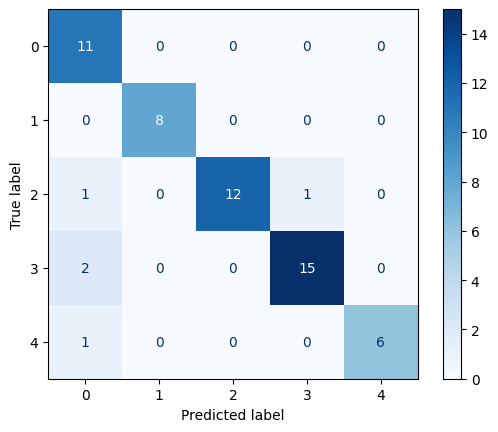

In [18]:
# CONFUSION MATRIX
model.trainable = False
pred_test = model.predict(X_test_indices)
Ypred_test = np.argmax(pred_test, axis=1)

print("\n------------Confusion Matrix------------")
emoji_labels = list(np.unique(Y_train))
# Generate the string with emojis
emoji_str = '            ' + ' '.join(convert_label_to_emoji(label) for label in emoji_labels)
print(emoji_str)
print(pd.crosstab(Y_test, Ypred_test.reshape(Y_test.shape,), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, Ypred_test, c_map=plt.cm.Blues)

In [20]:
# Final comments: 
# The current model can be improved by increasing the training set size and including more examples with negation.
# A larger dataset would enhance the LSTM model's ability to handle complex sentences compared to Sentiment_Analysis_v1.
# This project focuses on using pre-trained GloVe embeddings and LSTM to capture word order for sentiment analysis.